In [1]:
# Dependencies
import numpy as np
import cv2
from PIL import Image
import open3d as o3d

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords

from typing import Tuple, List, Dict, Union

%matplotlib inline

## Loading the dataset

In [2]:
#nusc = NuScenes(version='v1.0-mini',dataroot='/content/drive/My Drive/AI_S/ML/NuScenes/v1.0-mini')
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.2 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Obtaining Scene

In [3]:
# Select Scene 9
my_scene = nusc.scene[9]
my_scene

{'token': 'e233467e827140efa4b42d2b4c435855',
 'log_token': '8fefc430cbfa4c2191978c0df302eb98',
 'nbr_samples': 40,
 'first_sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'last_sample_token': 'abf3d91d3c28407e80e3334fe89c03cb',
 'name': 'scene-1100',
 'description': 'Night, peds in sidewalk, peds cross crosswalk, scooter, PMD, difficult lighting'}

In [4]:
# Obtain First sample token from the scene
first_sample_token = my_scene['first_sample_token']

## Obtaining a sample from Scene

In [5]:
# Get sample from token
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'a480496a5988410fbe3d8ed6c84da996',
 'timestamp': 1542800987947699,
 'prev': '',
 'next': 'b993550e60054741983f8052ba97b0b0',
 'scene_token': 'e233467e827140efa4b42d2b4c435855',
 'data': {'RADAR_FRONT': '511dba7f4aec41ea8baa9019ba97413c',
  'RADAR_FRONT_LEFT': 'b5a62f9cf0ac444cbd90c2f9ba7fedbf',
  'RADAR_FRONT_RIGHT': 'e95132afd0604448b6d522a09bad7e2d',
  'RADAR_BACK_LEFT': 'cb1a9aa2b8154fde9442eaa9fe11a958',
  'RADAR_BACK_RIGHT': 'f2008e1cb0194ee49a85243ed8261955',
  'LIDAR_TOP': 'b723df2123fe473d85512c9d02156c27',
  'CAM_FRONT': '51ceae8a5ecc4730950666723c135bc8',
  'CAM_FRONT_RIGHT': '4a85ae2a6329487abed596b0b7b6dfa4',
  'CAM_BACK_RIGHT': '646b51a45a2b4494a918ff89d36027e2',
  'CAM_BACK': 'd340a8d85c874b8d9e9ddf51a82a5908',
  'CAM_BACK_LEFT': 'c418396afb5a43a4af9a3b76278fd8d6',
  'CAM_FRONT_LEFT': '255a0637ea9a461989d7fb20f4ee126c'},
 'anns': ['9ca2a9ab9b5041278eea928681e09d89',
  '9dfee0c127f548acb80bf95610437acb',
  'b2222d3c49c447ba91247501e97d772b',
  '723bee443cf6433a9

## Obtaining a instance 

{'token': 'fb2873a3231945249b1fe1acf0cedf1d',
 'sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'instance_token': '88b7a3d6e9394198a1511642a5aa5499',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [1315.676, 902.276, 0.406],
 'size': [1.836, 4.416, 1.43],
 'rotation': [0.8854193832467303, 0.0, 0.0, 0.4647929816283586],
 'prev': '',
 'next': '59ea3960081c49a4a579e83805f5efe2',
 'num_lidar_pts': 659,
 'num_radar_pts': 1,
 'category_name': 'vehicle.car'}

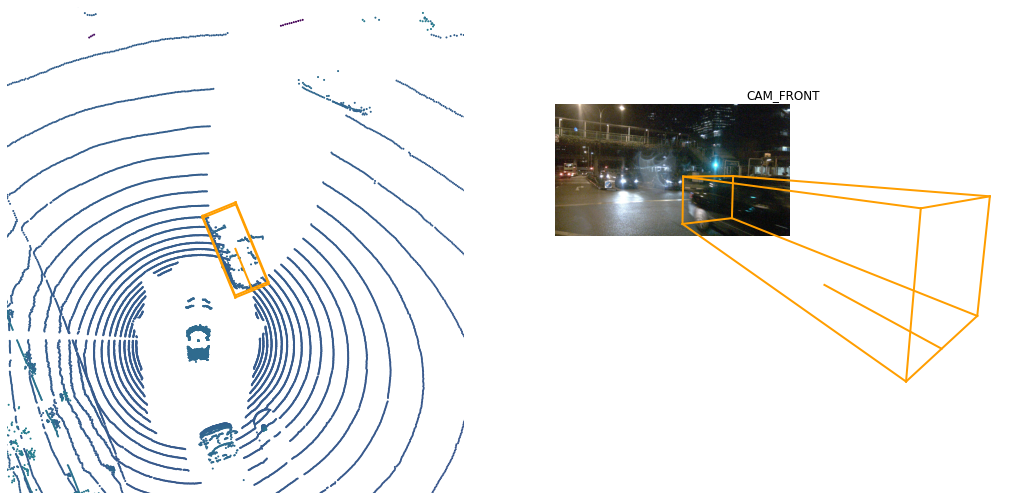

In [7]:
# Obtain the token from an instance in the sample
my_annotation_token = my_sample['anns'][23] #14 23
#gets sample ann from token
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
nusc.render_annotation(my_annotation_token)
my_annotation_metadata

# Get Camera data
This method brings the Camera channel in which the box is located.

In [8]:
def get_camera_data(annotation_token: str,
                    box_vis_level: BoxVisibility = BoxVisibility.ANY):
    
    """
    Given an annotation token (3d detection in world coordinate frame) this method 
    returns the camera in which the annotation is located. If the box is splitted 
    between 2 cameras, it brings the first one found.
    :param annotation_token: Annotation token.
    :return camera data.
    """
    
    #Get sample annotation
    ann_record = nusc.get('sample_annotation', annotation_token)

    sample_record = nusc.get('sample', ann_record['sample_token'])
  
    boxes, cam = [], []

    #Stores every camera
    cams = [key for key in sample_record['data'].keys() if 'CAM' in key]

    #Try with every camera a match for the annotation
    for cam in cams:
        _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], box_vis_level=box_vis_level,
                                                selected_anntokens=[annotation_token])
        if len(boxes) > 0:
            break  # Breaks if find an image that matches
    assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"
    
    return cam

## Obtaining a sample from a Camera

Sensor camera:  CAM_FRONT
The camera dictionary is: 
{'token': '51ceae8a5ecc4730950666723c135bc8', 'sample_token': 'a480496a5988410fbe3d8ed6c84da996', 'ego_pose_token': '51ceae8a5ecc4730950666723c135bc8', 'calibrated_sensor_token': 'd47224c723db443cb30a6c9d111adb7b', 'timestamp': 1542800987912460, 'fileformat': 'jpg', 'is_key_frame': True, 'height': 900, 'width': 1600, 'filename': 'samples/CAM_FRONT/n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542800987912460.jpg', 'prev': '', 'next': 'fc75e31c39a446cbac3e6ec054fd9172', 'sensor_modality': 'camera', 'channel': 'CAM_FRONT'}


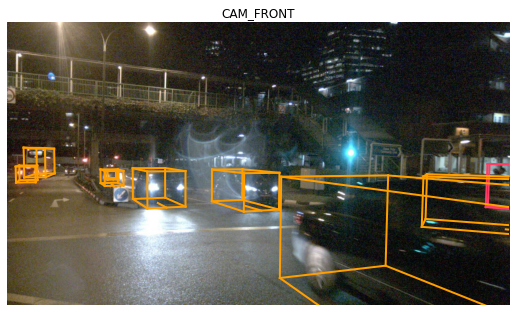

In [9]:
# Get camera to use
sensor_camera = get_camera_data(my_annotation_metadata['token'])
print("Sensor camera: ",sensor_camera)

# Sample data from Sensor
cam_data = nusc.get('sample_data', my_sample['data'][sensor_camera])
# Render the current scene
nusc.render_sample_data(cam_data['token'])
# Print the dictionary
print('The camera dictionary is: \n{}'.format(cam_data))

## Transformation instances from the current camera sensor

In [10]:
# Get the calibrated sensor and ego pose record to get the transformation matrices.
# From camera to ego
cs_rec = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
# From ego to world coordinate frame
pose_rec = nusc.get('ego_pose', cam_data['ego_pose_token'])
# Camera intrinsic parameters
camera_intrinsic = np.array(cs_rec['camera_intrinsic'])

## Printing the instance's target attributes

In [11]:
# Get the box in global coordinates from sample ann token 
box = nusc.get_box(my_annotation_metadata['token'])
print("The target's label is: \n{}".format(box))
print('The number of lidar points hitting the target are: {}'.format(my_annotation_metadata['num_lidar_pts']))
my_annotation_metadata

The target's label is: 
label: nan, score: nan, xyz: [1315.68, 902.28, 0.41], wlh: [1.84, 4.42, 1.43], rot axis: [0.00, 0.00, 1.00], ang(degrees): 55.39, ang(rad): 0.97, vel: nan, nan, nan, name: vehicle.car, token: fb2873a3231945249b1fe1acf0cedf1d
The number of lidar points hitting the target are: 659


{'token': 'fb2873a3231945249b1fe1acf0cedf1d',
 'sample_token': 'a480496a5988410fbe3d8ed6c84da996',
 'instance_token': '88b7a3d6e9394198a1511642a5aa5499',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [1315.676, 902.276, 0.406],
 'size': [1.836, 4.416, 1.43],
 'rotation': [0.8854193832467303, 0.0, 0.0, 0.4647929816283586],
 'prev': '',
 'next': '59ea3960081c49a4a579e83805f5efe2',
 'num_lidar_pts': 659,
 'num_radar_pts': 1,
 'category_name': 'vehicle.car'}

## Mapping the Box from World coordinate to Camera coordinate

In [12]:
# Mapping the box from world coordinate-frame to camera sensor
# Move them to the ego-pose frame.
box.translate(-np.array(pose_rec['translation']))
box.rotate(Quaternion(pose_rec['rotation']).inverse)

# Move them to the calibrated sensor frame.
box.translate(-np.array(cs_rec['translation']))
box.rotate(Quaternion(cs_rec['rotation']).inverse)

## Filter the box for data in Z < 0 (behind the camera)

In [13]:
# Filter out the corners that are not in front of the calibrated sensor.
# 8 corners of the 3d bounding box
corners_3d = box.corners()
# corners that are behind the sensor are removed
in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
corners_3d = corners_3d[:, in_front]

In [14]:
# Project 3d box to 2d.
corner_coords = view_points(corners_3d, camera_intrinsic, True).T[:, :2].tolist()
print("Box number of coords: {}".format(np.array(corner_coords).shape))

Box number of coords: (8, 2)


## Plot the results

min_x: 868
min_y: 487
max_x: 1600
max_y: 900


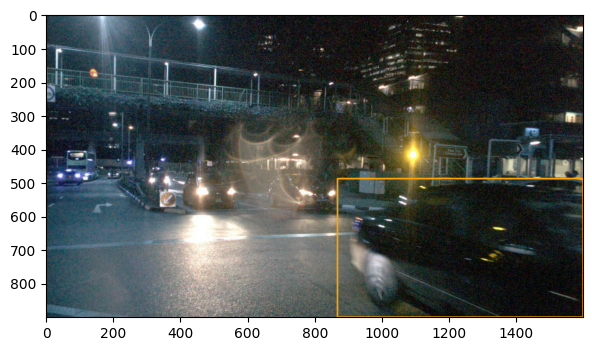

In [15]:
# Extract coorners
# Filter points that are outside the image
final_coords = post_process_coords(corner_coords)

min_x, min_y, max_x, max_y = [int(coord) for coord in final_coords]

print("min_x: {}".format(min_x))
print("min_y: {}".format(min_y))
print("max_x: {}".format(max_x))
print("max_y: {}".format(max_y))

# Load image from dataroot
img_path = osp.join(nusc.dataroot, cam_data['filename'])
img = cv2.imread(img_path, 1)

# Draw rectangle on image with coords
img_r = cv2.rectangle(img, (min_x,min_y),(max_x,max_y),(255, 165, 0) , 3)

plt.figure(figsize=(12, 4), dpi=100)
plt.imshow(img_r)
plt.show()

# Mapping Target to Camera

This short method maps a label in the world-coordinate frame to point sensor coordinate frame.

In [16]:
def target_to_cam(pointsensor_token: str,
                  annotation_token: str,
                  pointsensor_channel: str = 'LIDAR_TOP'):
    """
    Given an annotation token (3d detection in world coordinate frame) and pointsensor sample_data token,
    transform the label from world-coordinate frame to LiDAR.
    :param pointsensor_token: Lidar/radar sample_data token.
    :param annotation_token: Camera sample_data token.
    :param pointsensor_channel: Point sensor channel.
    :return box with the labels for the 3d detection task.
    """
    
    # Camera sample        
    point_data = nusc.get('sample_data', pointsensor_token) # Sample LiDAR info
        
    # From LiDAR to ego
    cs_rec = nusc.get('calibrated_sensor', point_data['calibrated_sensor_token'])
    # Transformation metadata from ego to world coordinate frame
    pose_rec = nusc.get('ego_pose', point_data['ego_pose_token'])
    
    # Obtain the annotation from the token
    annotation_metadata =  nusc.get('sample_annotation', annotation_token)
    
    # Obtain box parameters
    box = nusc.get_box(annotation_metadata['token'])
                                           
    # Move them to the ego-pose frame.
    box.translate(-np.array(pose_rec['translation']))
    box.rotate(Quaternion(pose_rec['rotation']).inverse)

    # Move them to the calibrated sensor frame.
    box.translate(-np.array(cs_rec['translation']))
    box.rotate(Quaternion(cs_rec['rotation']).inverse)
    
    return box

In [17]:
sensor_laser = 'LIDAR_TOP'

# Sample data from Sensor
point_data = nusc.get('sample_data', my_sample['data'][sensor_laser])

new_box = target_to_cam(point_data['token'], my_annotation_token, pointsensor_channel = 'LIDAR_TOP')
print(new_box)

label: nan, score: nan, xyz: [1.90, 4.65, -1.05], wlh: [1.84, 4.42, 1.43], rot axis: [-0.05, -0.04, 1.00], ang(degrees): -67.86, ang(rad): -1.18, vel: nan, nan, nan, name: vehicle.car, token: fb2873a3231945249b1fe1acf0cedf1d


## Using RANSAC to segment the floor in the current point cloud

In [18]:
def segment_floor(points: np.array,
                  coloring: np.array,
                  ori_points: np.array,
                  imsize: Tuple[float, float] = (1600, 900),
                  dist_thresh: float = 0.3,
                  min_dist: float = 1.0) -> Tuple:
    """
    Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image
    plane.
    :param points: <np.float: 2, n> point cloud mapped in the image frame
    :param coloring: <np.float: n> depth of the point cloud in the camera frame
    :param ori_points: <np.float: 3, n> point cloud in LiDAR coordinate frame
    :param imsize: Size of image to render. The larger the slower this will run.
    :param dist_thresh: Threshold to consider points within floor plane.
    :param min_dist: Distance from the camera below which points are discarded.
    :return (points_img <np.float: 2, n)>, coloring_img <np.float: n>, ori_points_img<np.float: 3, n)>).
    """

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    mask_img = np.ones(coloring.shape[0], dtype=bool)
    mask_img = np.logical_and(mask_img, coloring > min_dist)
    mask_img = np.logical_and(mask_img, points[0, :] > 1)
    mask_img = np.logical_and(mask_img, points[0, :] < imsize[0] - 1)
    mask_img = np.logical_and(mask_img, points[1, :] > 1)
    mask_img = np.logical_and(mask_img, points[1, :] < imsize[1] - 1)

    # Filter the points within the image with the generated mask
    points_img = points[:, mask_img]
    coloring_img = coloring[mask_img]
    ori_points_img = ori_points[:, mask_img]
    
    # Segmenting the point cloud's floor
    lidar_points = np.asarray(ori_points_img.T, np.float32)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(lidar_points)

    # inliers are the indeces of the the inliers (plane points)
    plane_model, inliers = pcd.segment_plane(distance_threshold = dist_thresh,
                                            ransac_n = 20,
                                            num_iterations = 1000)
    # Obtaining the plane's equation
    [a, b, c, d] = plane_model
    # print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    # These lines plot the point cloud inliers and outliers
    # inlier_cloud = pcd.select_by_index(inliers)
    # inlier_cloud.paint_uniform_color([1.0, 0, 0])
    # outlier_cloud = pcd.select_by_index(inliers, invert=True)
    # o3d.visualization.draw_geometries([outlier_cloud])

    # Create a floor mask with the indeces inverted, points that are not in plane are of interest
    mask_floor = np.arange(points_img.shape[1])
    mask_floor = np.full(points_img.shape[1], True, dtype=bool)
    mask_floor[inliers] = False

    # Filter the points which are floor
    points_img = points_img[:, mask_floor]
    coloring_img = coloring_img[mask_floor]
    ori_points_img = ori_points_img[:, mask_floor]
        
    return points_img, coloring_img, ori_points_img

# Mapping Lidar and Radar point Cloud to interest instance

In [19]:
def map_pointcloud_to_image_(bbox,
                             pointsensor_token: str,
                             camera_token: str,
                             min_dist: float = 1.0,
                             visualize: bool = False) -> Tuple:
        """
        Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image
        plane.
        :param bbox: object coordinates in the current image.
        :param pointsensor_token: Lidar/radar sample_data token.
        :param camera_token: Camera sample_data token.
        :param min_dist: Distance from the camera below which points are discarded.
        :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
        """
        cam = nusc.get('sample_data', camera_token) # Sample camera info
        pointsensor = nusc.get('sample_data', pointsensor_token) # Sample point cloud
        # pcl_path is the path from root to the pointCloud file
        pcl_path = osp.join(nusc.dataroot, pointsensor['filename']) 
        # Open the pointCloud path using the Lidar or Radar class
        if pointsensor['sensor_modality'] == 'lidar':
            # Read point cloud with LidarPointCloud (4 x samples) --> X, Y, Z and intensity
            pc = LidarPointCloud.from_file(pcl_path)
            # To access the points pc.points
        else:
            # Read point cloud with LidarPointCloud (18 x samples) --> 
            # https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/utils/data_classes.py#L296
            pc = RadarPointCloud.from_file(pcl_path)
                        
        # Open image of the interest camera
        im = Image.open(osp.join(nusc.dataroot, cam['filename']))
        
        # Save original points (X, Y and Z) coordinates in LiDAR frame
        ori_points = pc.points[:3, :].copy()
        
        # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
        # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
        cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token']) # Transformation matrix of pointCloud
        # Transform the Quaternion into a rotation matrix and use method rotate in PointCloud class to rotate
        # Map from the laser sensor to ego_pose
        # The method is a dot product between cs_record['rotation'] (3 x 3) and points (3 x points)
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        # Add the traslation vector between ego vehicle and sensor
        # The method translate is an addition cs_record['translation'] (3,) and points (3 x points)
        pc.translate(np.array(cs_record['translation']))

        # Second step: transform to the global frame.
        poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        # Same step as before, map from ego_pose to world coordinate frame
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
        pc.translate(np.array(poserecord['translation']))

        # Third step: transform into the ego vehicle frame for the timestamp of the image.
        poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
        # Same step as before, map from world coordinate frame to ego vehicle frame for the timestamp of the image.
        pc.translate(-np.array(poserecord['translation']))
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

        # Fourth step: transform into the camera.
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        # Same step as before, map from ego at camera timestamp to camera
        pc.translate(-np.array(cs_record['translation']))
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

        # Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]
        
        # Retrieve the color from the depth.
        coloring = depths

        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        # Normalization means to divide the X and Y coordinates by the depth
        # The output dim (3 x n_points) where the 3rd row are ones.
        points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
        
        # bounding box coordinates
        min_x, min_y, max_x, max_y = [int(points_b) for points_b in bbox]
        
        # Floor segmentation
        points_img, coloring_img, ori_points_img = segment_floor(points, coloring, ori_points,
                                                                (im.size[0], im.size[1]), 0.05, 1.0)
                
        # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
        # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
        # casing for non-keyframes which are slightly out of sync.
        # Create a mask of bools the same size of depth points
        mask_ann = np.ones(coloring_img.shape[0], dtype=bool)
        # Keep points such as X coordinate is bigger than bounding box minimum coordinate
        mask_ann = np.logical_and(mask_ann, points_img[0, :] > min_x + 1)
        # remove points such as X coordinate is bigger than bounding box maximum coordinate
        mask_ann = np.logical_and(mask_ann, points_img[0, :] < max_x - 1)
        # Keep points such as Y coordinate is bigger than bounding box minimum coordinate
        mask_ann = np.logical_and(mask_ann, points_img[1, :] > min_y + 1)
        # remove points such as Y coordinate is bigger than bounding box maximum coordinate
        mask_ann = np.logical_and(mask_ann, points_img[1, :] < max_y - 1)
        # Keep only the interest points
        points_ann = points_img[:, mask_ann]
        coloring_ann = coloring_img[mask_ann]
        ori_points_ann = ori_points_img[:, mask_ann]

        if visualize:
            plt.figure(figsize=(9, 16))
            plt.imshow(im)
            plt.scatter(points_ann[0, :], points_ann[1, :], c = coloring_ann, s = 5)
            plt.axis('off')
            
        return points_ann, coloring_ann, ori_points_ann, im

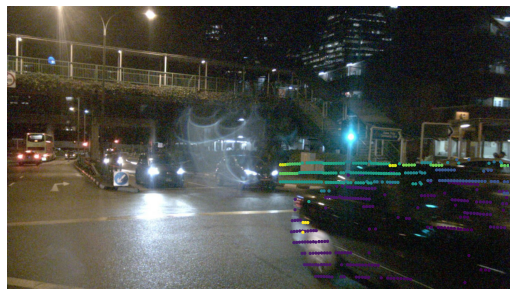

In [20]:
sensor_laser = 'LIDAR_TOP'

# Sample data from Sensor
point_data = nusc.get('sample_data', my_sample['data'][sensor_laser])
# Method to map a point cloud to a particular bounding box
points, coloring, ori_points, im = map_pointcloud_to_image_(final_coords, point_data['token'], 
                                                            cam_data['token'], visualize = True)

In [21]:
# Points in current image frame
print('The shape of the points in the image are: {}'.format(points.shape))
# Depths of the points in the image frame
print('The shape of the depths in the image are: {}'.format(coloring.shape))
# Filtered points in camera coordinates
print('The shape of the original points in the camera frame are: {}'.format(ori_points.shape))

The shape of the points in the image are: (3, 430)
The shape of the depths in the image are: (430,)
The shape of the original points in the camera frame are: (3, 430)


In [22]:
# plotting original point cloud

pointsensor = nusc.get('sample_data', point_data['token'])
pcl_path = osp.join(nusc.dataroot, pointsensor['filename']) 
pc = LidarPointCloud.from_file(pcl_path)
pts = pc.points[:-1, :]

Velopoints = np.asarray(pts.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])


In [23]:
# Plotting the segmented point cloud
Velopoints = np.asarray(ori_points.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])

## Computing 2D Bounding box

In [24]:
def bbox_3d_to_2d(camera_token: str,
                  annotation_token: str,
                  visualize: bool = False) -> List:
    
    # Obtain camera sample_data
    cam_data = nusc.get('sample_data', camera_token)

    # Get the calibrated sensor and ego pose record to get the transformation matrices.
    
    # From camera to ego
    cs_rec = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    # From ego to world coordinate frame
    pose_rec = nusc.get('ego_pose', cam_data['ego_pose_token'])
    # Camera intrinsic parameters
    camera_intrinsic = np.array(cs_rec['camera_intrinsic'])
    
    # Obtain the annotation from the token
    annotation_metadata =  nusc.get('sample_annotation', annotation_token)

    # Get the box in global coordinates from sample ann token 
    box = nusc.get_box(annotation_metadata['token'])

    # Mapping the box from world coordinate-frame to camera sensor
    
    # Move them to the ego-pose frame.
    box.translate(-np.array(pose_rec['translation']))
    box.rotate(Quaternion(pose_rec['rotation']).inverse)

    # Move them to the calibrated sensor frame.
    box.translate(-np.array(cs_rec['translation']))
    box.rotate(Quaternion(cs_rec['rotation']).inverse)

    # Filter out the corners that are not in front of the calibrated sensor.
    corners_3d = box.corners() # 8 corners of the 3d bounding box
    in_front = np.argwhere(corners_3d[2, :] > 0).flatten() # corners that are behind the sensor are removed
    corners_3d = corners_3d[:, in_front]

    # Project 3d box to 2d.
    corner_coords = view_points(corners_3d, camera_intrinsic, True).T[:, :2].tolist()
    
    # Filter points that are outside the image
    final_coords = post_process_coords(corner_coords)

    min_x, min_y, max_x, max_y = [int(coord) for coord in final_coords]
    
    if visualize:
        # Load image from dataroot
        img_path = osp.join(nusc.dataroot, cam_data['filename'])
        img = cv2.imread(img_path, 1)

        # Draw rectangle on image with coords
        img_r = cv2.rectangle(img, (min_x,min_y),(max_x,max_y),(255, 165, 0) , 3)

        plt.figure(figsize=(12, 4), dpi=100)
        plt.imshow(img_r)
        plt.show()
        
    return final_coords

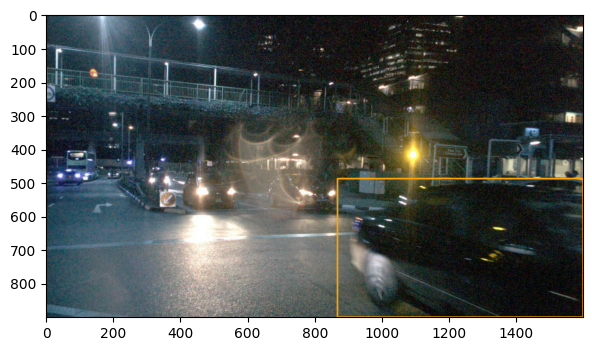

In [25]:
coords = bbox_3d_to_2d(camera_token = cam_data['token'], annotation_token = my_annotation_token, visualize = True)

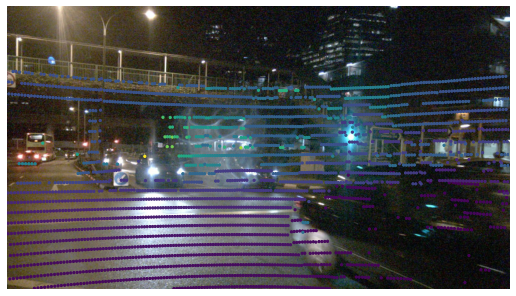

In [26]:
nusc.render_pointcloud_in_image(my_sample['token'], camera_channel = sensor_camera, pointsensor_channel='LIDAR_TOP')

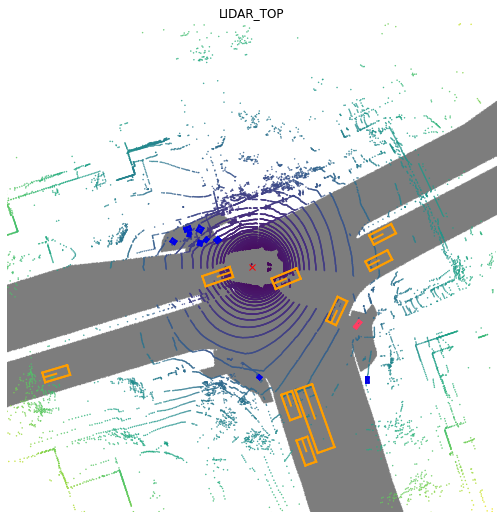

In [27]:
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=True)